# Two Sector Hank (Formal and Informal with Labor Mobility)

There is a continuum of ex-ante identical households. They can either work in the formal ($f$) or informal ($i$) sector. The sector allocation is given by the markov transition matrix.

\begin{align}
    \begin{pmatrix}
        p(f \to f) & p(f \to i) \\
        p(i \to f) & p(i \to i)
    \end{pmatrix}
\end{align}

Working in each sector has implications in the following dimensions:
1. Income process
- Wage and tax rate
- permanent and transitory shocks
- Unemployment probability and income at unemployment
2. Financial access
- Borrowing constraint
- Interest rate
3. Preferences
- Living Probability

Most importantly, the government can only collect taxes from the formal sector. 

Note that HARK takes disposable income as input, which is calculated by
$$
Z_t = Y_t - T_t
$$
With $p$ the proportion of workers in the formal sector, we have

$$
Z_{t,f} = Y_t * p - T_t \\
Z_{t,i} = Y_t * (1 - p)
$$

With different wage rates (notate w the share of wage rate in the formal vs informal sector)
$$
Z_{t,f} = Y_t * p * w- T_t \\
Z_{t,i} = Y_t * (1 - p) / w
$$

In [1]:
import matplotlib.pyplot as plt
from TwoSectorModel_HANK import TwoSectorMarkovConsumerType
import numpy as np
from copy import copy, deepcopy

from scipy import optimize


import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
import matplotlib.pyplot as plt
import time



In [2]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

In [3]:
# Define the Markov transition matrix for sector f(ormal) to i(nformal)
p_f_to_i = 0.5
p_i_to_f = 0.5
p_f_to_f = 1 - p_f_to_i
p_i_to_i = 1 - p_i_to_f

MrkvArray = np.array(
    [
        [
            p_f_to_f
        ,
            p_f_to_i
        ],
        [
           p_i_to_f
        ,
            p_i_to_i
        ]
    ]
)

NSectors = 2

In [4]:
## psize is the size of the formal sector.
psize = 0.5
pformal_share = psize/(1-psize)
wage_share = 1.2

In [5]:
UnempPrb_f = 0.05
IncUnemp_f = 0.7

In [6]:
# Defining steady state values of the economy
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B + (UnempPrb_f * IncUnemp_f) * psize    
    return T

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.7 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)
print('T_ss: ' +str(T_ss))

# Z_ss = Y_ss - T_ss
Zf_ss = Y_ss * wage_share * pformal_share - T_ss / psize
Zi_ss = Y_ss / (wage_share * pformal_share) # One One Sector can be taxed

C_ss = Y_ss - G_ss

print('Zf_ss: ' +str(Zf_ss))
print('Zi_ss: ' +str(Zi_ss))
print('C_ss: ' +str(Y_ss - G_ss))

T = 300 # Dimention of TxT Jacobian matrix

T_ss: 0.23850000000000007
Zf_ss: 0.7229999999999999
Zi_ss: 0.8333333333333334
C_ss: 0.8


In [7]:
T_cycles = 1
cycles = 0
LivPrb = .99375

PermShkStd_f = 0.06
PermShkStd_i = 0.06
TranShkStd_f = 0.2
TranShkStd_i = 0.2
PermGroFac_f = 1.0
PermGroFac_i = 1.0
# UnempPrb_f = 0.1
UnempPrb_i = 0.05
# IncUnemp_f = 0.7
IncUnemp_i = 0.0
taxrate_f = 0.0
taxrate_i = 0.0
# labor_f = 0.8
# labor_i = 0.8 #0.6
wage_f = 1.0
wage_i = 1.0
BoroCnstArt_f = 0.0
BoroCnstArt_i = 0.0
LivPrb_f = .99375
LivPrb_i = .99375
PermGroFac_f = 1.0
PermGroFac_i = 1.0

init_twosector = {
    "cycles" : cycles,
    "T_cycle" : T_cycles,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.85,
    "Rfree": [np.array(2 * [1.03])] * T_cycles, #np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([PermShkStd_f, PermShkStd_i])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([TranShkStd_f, TranShkStd_i])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([UnempPrb_f, UnempPrb_i])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([IncUnemp_f, IncUnemp_i])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([taxrate_f, taxrate_i])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([Zf_ss, Zi_ss])] * T_cycles,  # Labor for each sector
    "wage": [np.array([wage_f, wage_i])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [BoroCnstArt_f, BoroCnstArt_i],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [np.array([LivPrb_f, LivPrb_i])] * T_cycles,
    "PermGroFac": [np.array([PermGroFac_f, PermGroFac_i])] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [psize, 1 - psize],

}


# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    z = (1- taxrate)*labor*wage
    
    return z

init_twosector['TranShkMean_Func'] = [function]

In [8]:
# Make a consumer with serially correlated unemployment, subject to boom and bust cycles
init_twosector["global_markov"] = False
TwoSectorExample = TwoSectorMarkovConsumerType(**init_twosector)


In [9]:
# ## RFREE WITH TIME VARYING
# TwoSectorExample.assign_parameters(
#     Rfree=[np.array(2 * [1.03])] * T_cycles
# )

In [10]:
TwoSectorExample.solve()

c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\interpolation.py:2187: RuntimeWarning: All-NaN slice encountered


In [11]:
### Plot Consumption Functions
mGrid = np.linspace(0, 100, 200)
mGrid = mGrid - 2

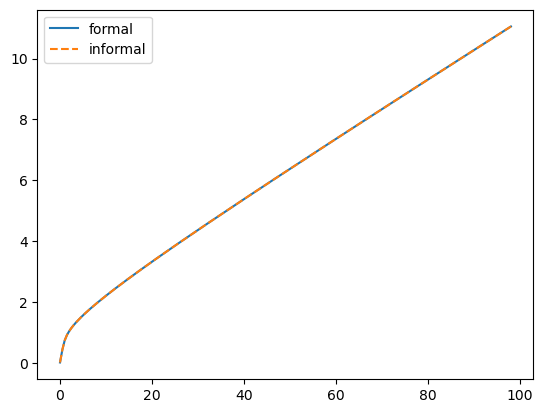

In [12]:
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[0](mGrid), label = 'formal')
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[1](mGrid), '--', label = 'informal')
plt.legend()

In [13]:
TwoSectorExample.compute_steady_state()

(0.403517912842829,
 0.7890610158214988,
 array([0.36592576, 0.44111006]),
 array([0.77183129, 0.80629074]))

In [14]:
CJACR, AJACR = TwoSectorExample.calc_jacobian("Rfree", 0, 300)

c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\interpolation.py:2187: RuntimeWarning: All-NaN slice encountered


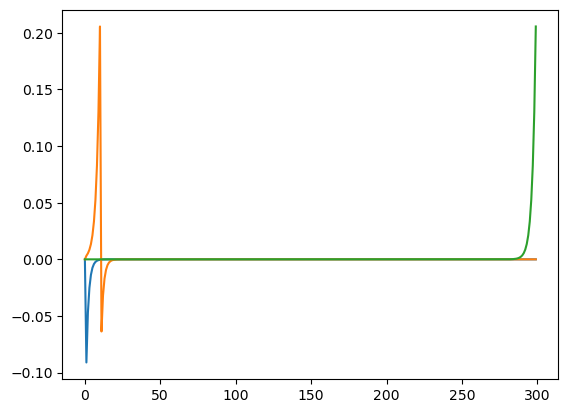

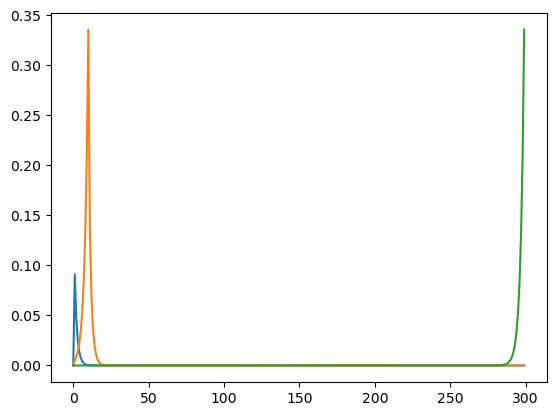

In [15]:
plt.plot(CJACR[0])
plt.plot(CJACR[10])
plt.plot(CJACR[-1])
plt.show()

plt.plot(AJACR[0])
plt.plot(AJACR[10])
plt.plot(AJACR[-1])

plt.show()

In [16]:
### Target Steady State Asset
def ss_func(beta):
    init_twosector['DiscFac'] = beta
    Agent_func = TwoSectorMarkovConsumerType(**init_twosector, verbose = False)
    A_ss = Agent_func.compute_steady_state()[0]
    return A_ss
    

def ss_dif(beta):  
    difference =   ss_func(beta) - Asset_target 
    return difference

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.75,.95)

In [17]:
DiscFac

0.9342407019922416

In [18]:
init_twosector['DiscFac'] = DiscFac
Agent_GE = TwoSectorMarkovConsumerType(**init_twosector)

In [19]:
A_ss, C_ss, A_ss_Markv, C_ss_Markv = Agent_GE.compute_steady_state()

In [20]:
print('A_ss: ', A_ss)
print('C_ss: ', C_ss)
print('A_ss per Markov State: ', A_ss_Markv)
print('C_ss per Markov State: ', C_ss_Markv)

A_ss:  0.7000000000033886
C_ss:  0.7960468750001407
A_ss per Markov State:  [0.65405191 0.74594809]
C_ss per Markov State:  [0.78717309 0.80492066]


In [21]:
### Input changes for both Agents
start = time.time()

CJACR, AJACR = Agent_GE.calc_jacobian('Rfree',0,T)
CJACZ, AJACZ = Agent_GE.calc_jacobian('labor', 0,T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 11.895519018173218


In [22]:
### Input changes for only one agent
start = time.time()

CJACR_f, AJACR_f = Agent_GE.calc_jacobian('Rfree',1,T)
CJACZ_f, AJACZ_f = Agent_GE.calc_jacobian('labor', 1,T)

CJACR_i, AJACR_i = Agent_GE.calc_jacobian('Rfree',2,T)
CJACZ_i, AJACZ_i = Agent_GE.calc_jacobian('labor', 2,T)
print('Seconds to calculate Jacobian', time.time() - start)


Seconds to calculate Jacobian 22.306212425231934


In [23]:
CJACR- CJACR_f - CJACR_i

array([[ 1.22124533e-11,  2.55783157e-06,  1.12350307e-06, ...,
         1.08121669e-12,  1.07622386e-12,  1.08121669e-12],
       [ 3.66373598e-11, -2.50834390e-06,  1.74592463e-06, ...,
         8.23603347e-13,  8.30750129e-13,  8.23603346e-13],
       [ 4.88498131e-11, -1.03374791e-06, -3.01884342e-06, ...,
         6.33309964e-13,  6.27441186e-13,  6.33309964e-13],
       ...,
       [ 5.69544412e-10,  6.66289151e-14,  9.68627088e-15, ...,
        -2.85946594e-06,  1.57797536e-06,  4.97819073e-07],
       [ 5.69544412e-10,  6.66289151e-14,  9.68627088e-15, ...,
        -9.55208302e-07, -2.85946595e-06,  1.57797536e-06],
       [ 5.69544412e-10,  6.66289151e-14,  9.68627088e-15, ...,
         3.00467643e-07, -9.55208304e-07, -2.85946595e-06]])

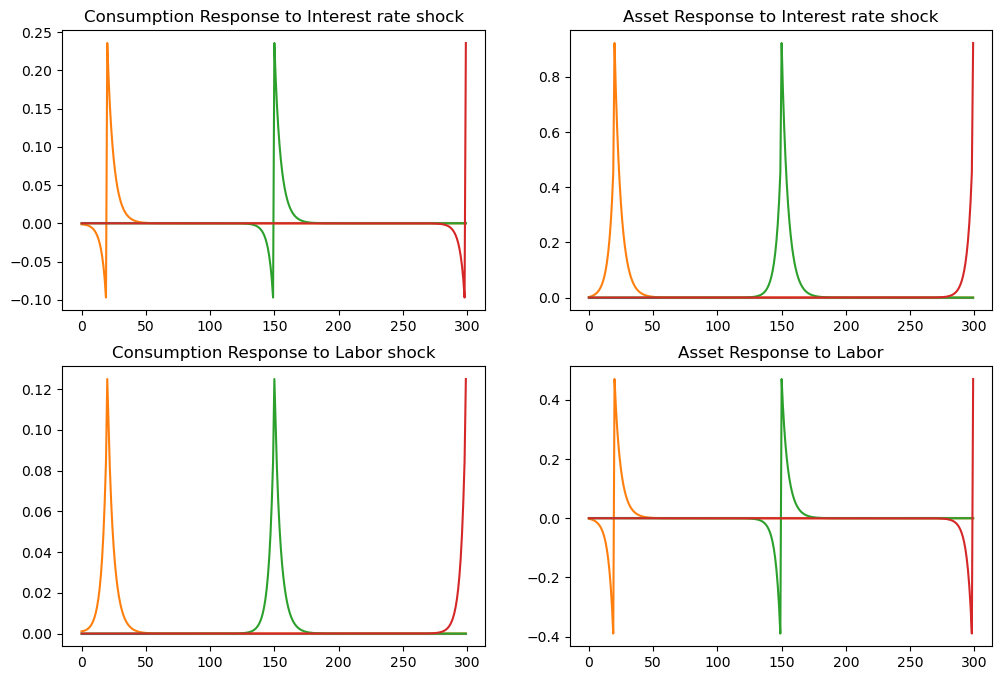

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR.T[0])
axs[0, 0].plot(CJACR.T[20])
axs[0, 0].plot(CJACR.T[150])
axs[0, 0].plot(CJACR.T[-1])
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Asset Response to Interest rate shock
axs[0, 1].plot(AJACR.T[0])
axs[0, 1].plot(AJACR.T[20])
axs[0, 1].plot(AJACR.T[150])
axs[0, 1].plot(AJACR.T[-1])
axs[0, 1].set_title("Asset Response to Interest rate shock")

# Consumption Response to Labor shock
axs[1, 0].plot(CJACZ.T[0])
axs[1, 0].plot(CJACZ.T[20])
axs[1, 0].plot(CJACZ.T[150])
axs[1, 0].plot(CJACZ.T[-1])
axs[1, 0].set_title("Consumption Response to Labor shock")

# Asset Response to Labor
axs[1, 1].plot(AJACZ.T[0])
axs[1, 1].plot(AJACZ.T[20])
axs[1, 1].plot(AJACZ.T[150])
axs[1, 1].plot(AJACZ.T[-1])
axs[1, 1].set_title("Asset Response to Labor")

plt.show()

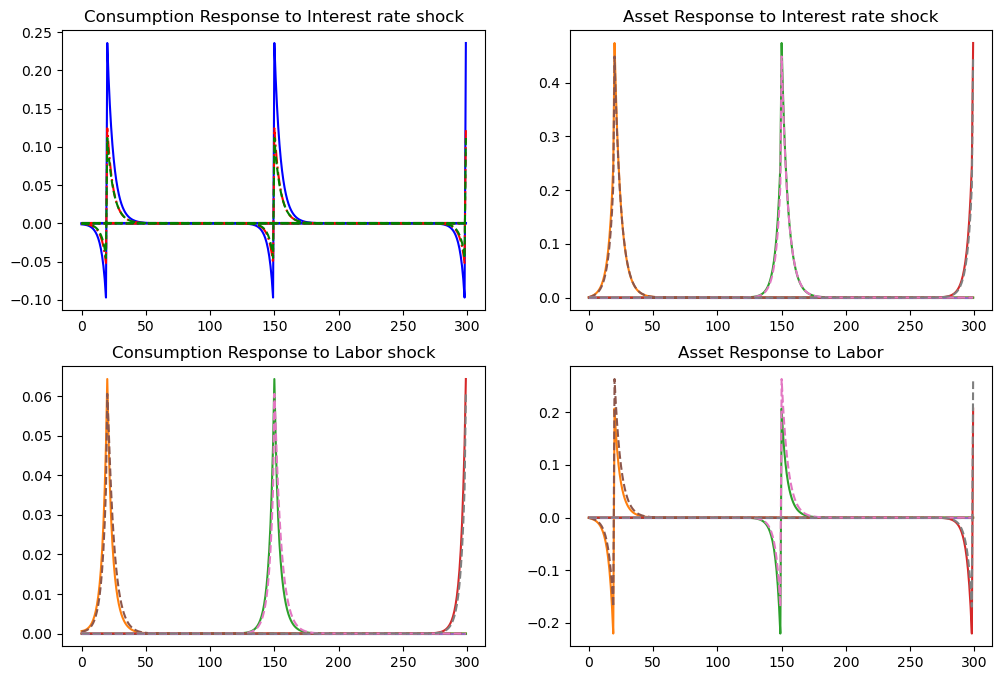

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR.T[0], color = 'blue')
axs[0, 0].plot(CJACR.T[20], color = 'blue')
axs[0, 0].plot(CJACR.T[150], color = 'blue')
axs[0, 0].plot(CJACR.T[-1], color = 'blue')
axs[0, 0].plot(CJACR_f.T[0], '-.', color = 'red', label = 'formal')
axs[0, 0].plot(CJACR_f.T[20], '-.', color = 'red', label = 'formal')
axs[0, 0].plot(CJACR_f.T[150], '-.', color = 'red', label = 'formal')
axs[0, 0].plot(CJACR_f.T[-1], '-.', color = 'red', label = 'formal')
axs[0, 0].plot(CJACR_i.T[0], '--', color = 'green', label = 'informal')
axs[0, 0].plot(CJACR_i.T[20], '--', color = 'green', label = 'informal')
axs[0, 0].plot(CJACR_i.T[150], '--', color = 'green', label = 'informal')
axs[0, 0].plot(CJACR_i.T[-1], '--', color = 'green', label = 'informal')
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Asset Response to Interest rate shock
axs[0, 1].plot(AJACR_f.T[0])
axs[0, 1].plot(AJACR_f.T[20])
axs[0, 1].plot(AJACR_f.T[150])
axs[0, 1].plot(AJACR_f.T[-1])
axs[0, 1].plot(AJACR_i.T[0], '--', label = 'informal')
axs[0, 1].plot(AJACR_i.T[20], '--', label = 'informal')
axs[0, 1].plot(AJACR_i.T[150], '--', label = 'informal')
axs[0, 1].plot(AJACR_i.T[-1], '--', label = 'informal')
axs[0, 1].set_title("Asset Response to Interest rate shock")

# Consumption Response to Labor shock
axs[1, 0].plot(CJACZ_f.T[0])
axs[1, 0].plot(CJACZ_f.T[20])
axs[1, 0].plot(CJACZ_f.T[150])
axs[1, 0].plot(CJACZ_f.T[-1])
axs[1, 0].plot(CJACZ_i.T[0], '--', label = 'informal')
axs[1, 0].plot(CJACZ_i.T[20], '--', label = 'informal')
axs[1, 0].plot(CJACZ_i.T[150], '--', label = 'informal')
axs[1, 0].plot(CJACZ_i.T[-1], '--', label = 'informal')
axs[1, 0].set_title("Consumption Response to Labor shock")

# Asset Response to Labor
axs[1, 1].plot(AJACZ_f.T[0])
axs[1, 1].plot(AJACZ_f.T[20])
axs[1, 1].plot(AJACZ_f.T[150])
axs[1, 1].plot(AJACZ_f.T[-1])
axs[1, 1].plot(AJACZ_i.T[0], '--', label = 'informal')
axs[1, 1].plot(AJACZ_i.T[20], '--', label = 'informal')
axs[1, 1].plot(AJACZ_i.T[150], '--', label = 'informal')
axs[1, 1].plot(AJACZ_i.T[-1], '--', label = 'informal')
axs[1, 1].set_title("Asset Response to Labor")

plt.show()

In [26]:
HARK_SteadyState_Dict = SteadyStateDict({"C": C_ss, "r": r_ss, "Y": Y_ss, "B": B_ss, "G": G_ss, "A": A_ss})
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'Zf' : CJACZ_f, 'Zi' : CJACZ_i, 'r': CJACR} ,'A' : {'Zf' : AJACZ_f, 'Zi' : AJACZ_i, 'r': AJACR} } ) 

In [27]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B + UnempPrb_f * IncUnemp_f * psize # total tax burden
    Zf = Y * pformal_share * wage_share - T/psize
    Zi = Y / (pformal_share * wage_share) 
    deficit = G - T
    
    return T, Zf, Zi, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt


In [28]:
# Create the model and specify attributes
HARK_HANK = create_model([HARK_Jacobian_Dict, fiscal, mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['G']

In [29]:
# First, we analyze a government spending shock.
G_std = .01
G_persistence = .8
dG =  G_std * G_persistence**np.arange(T)
shocks_G = {"G": dG}

In [30]:
# Create the IRFs
irfs_G = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_G)

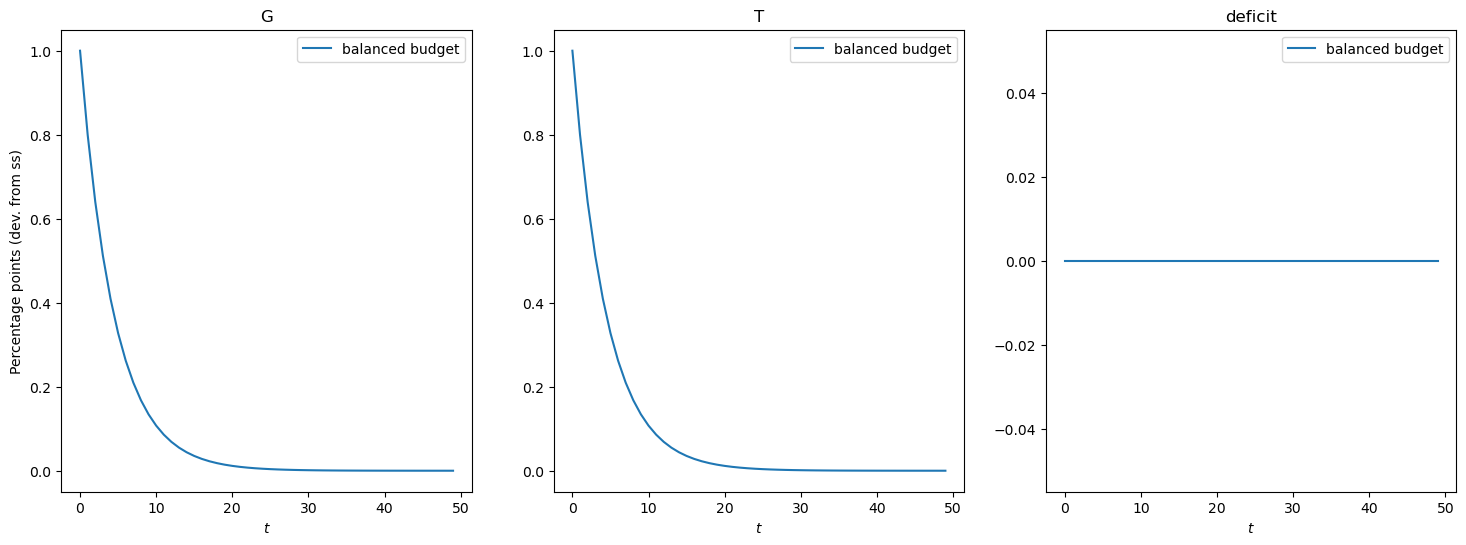

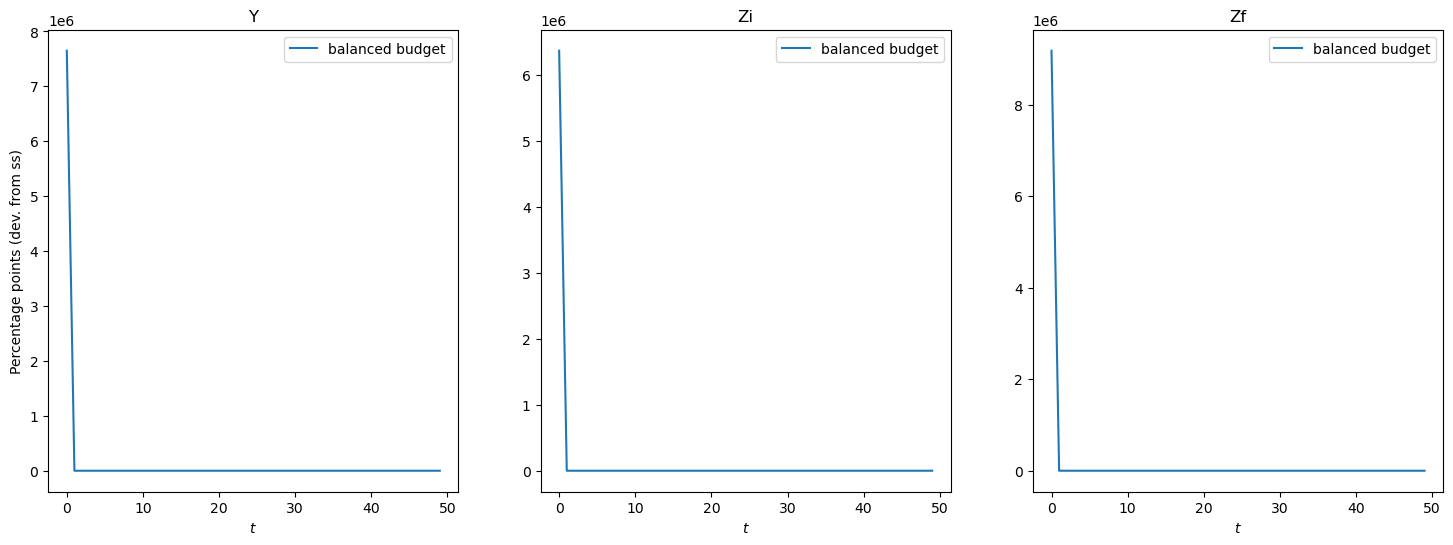

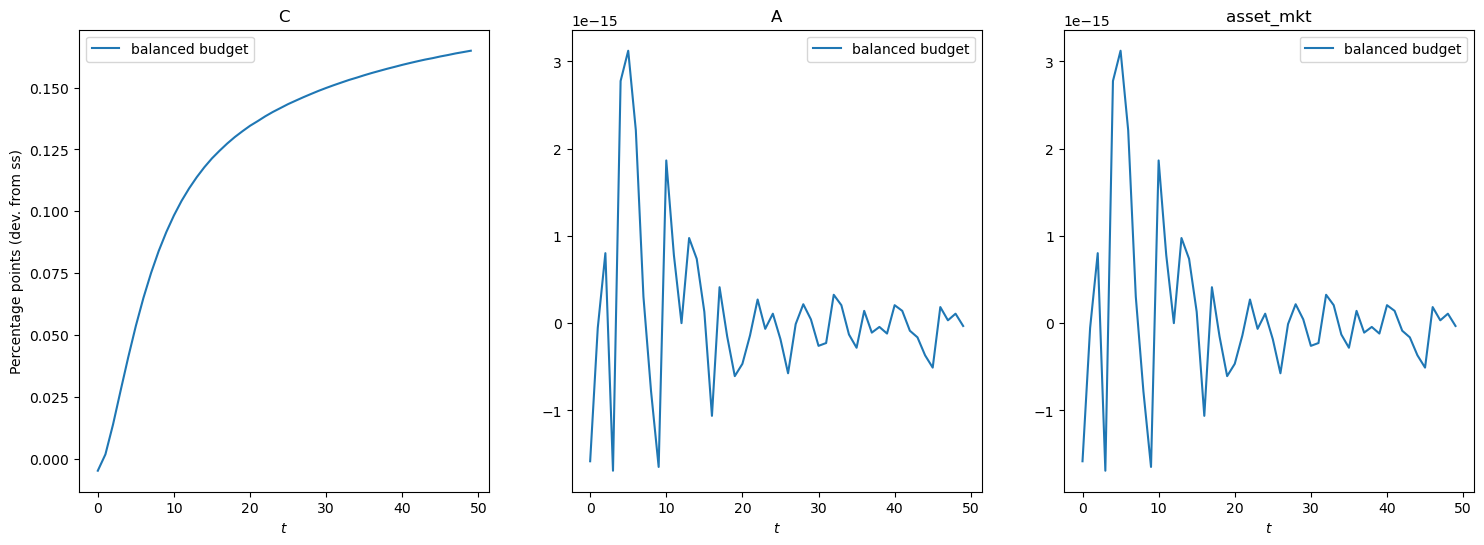

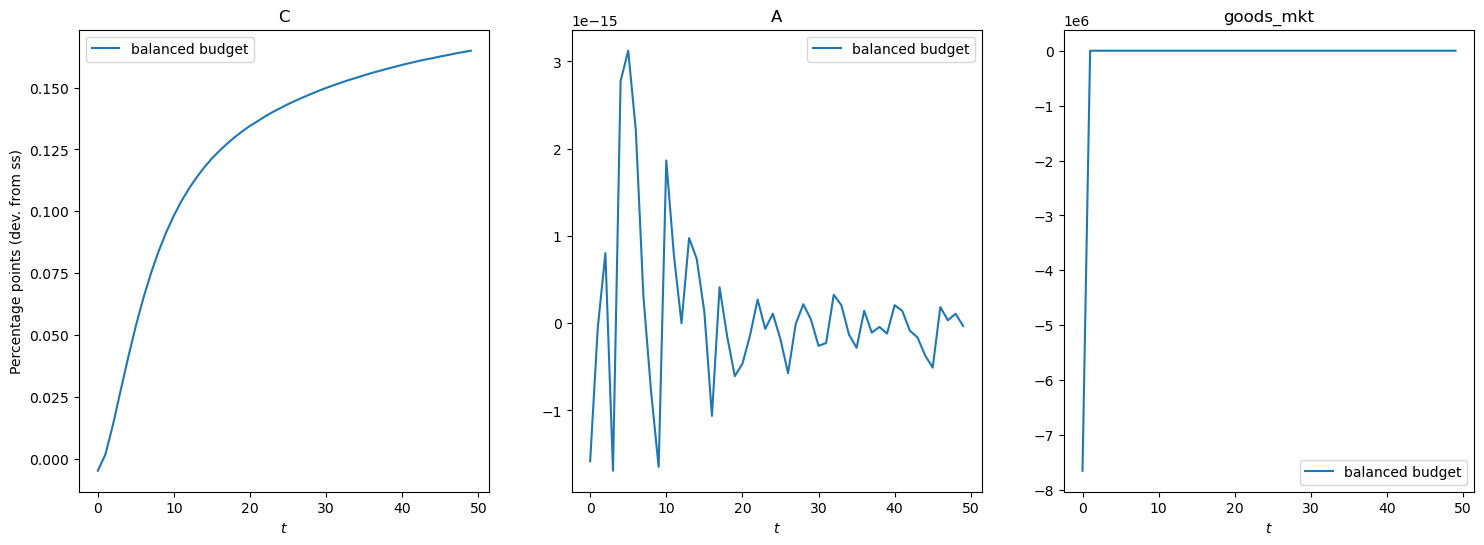

In [31]:
# Plot them
show_irfs([irfs_G], ['G', 'T', 'deficit'], labels=["balanced budget"])
show_irfs([irfs_G], ['Y', 'Zi', 'Zf'], labels=["balanced budget"])
show_irfs([irfs_G], ['C', 'A','asset_mkt'], labels=["balanced budget"])
show_irfs([irfs_G], ['C', 'A','goods_mkt'], labels=["balanced budget"])

# show_irfs([irfs_G], [, 'goods_mkt'], labels=["balanced budget"])

In [32]:
# Deficit Spending
rho_B = 0.8
dB = np.cumsum(dG) * rho_B ** np.arange(T)
shocks_B = {'G': dG, 'B': dB}

irfs_B = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_B)

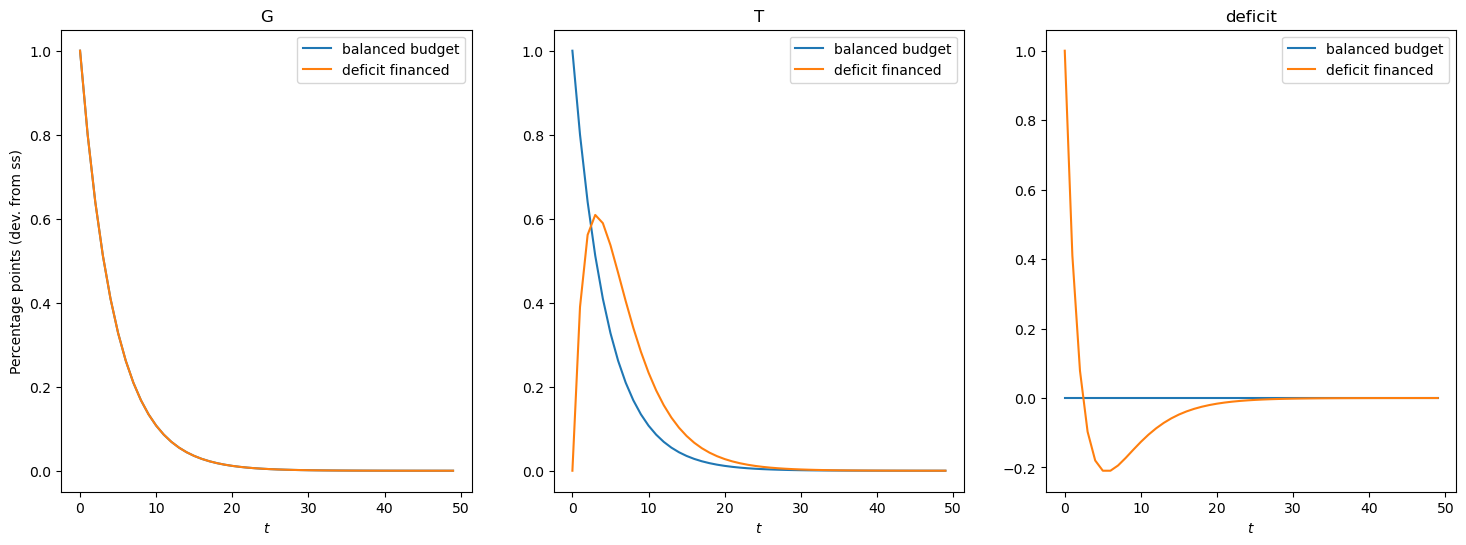

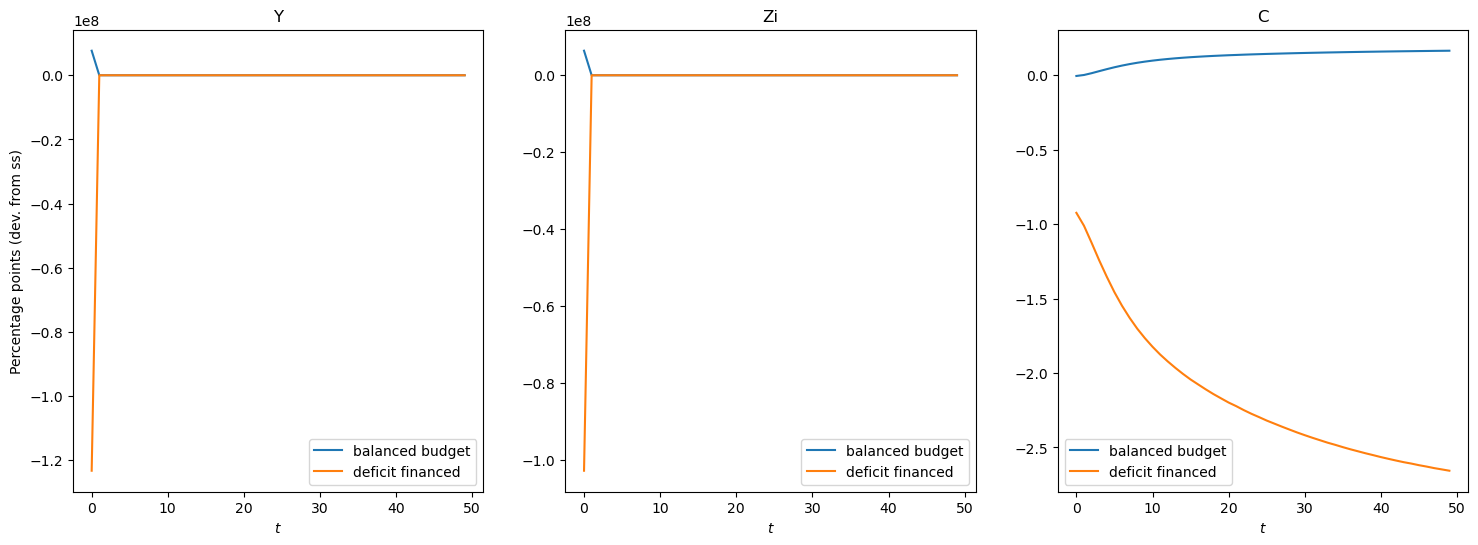

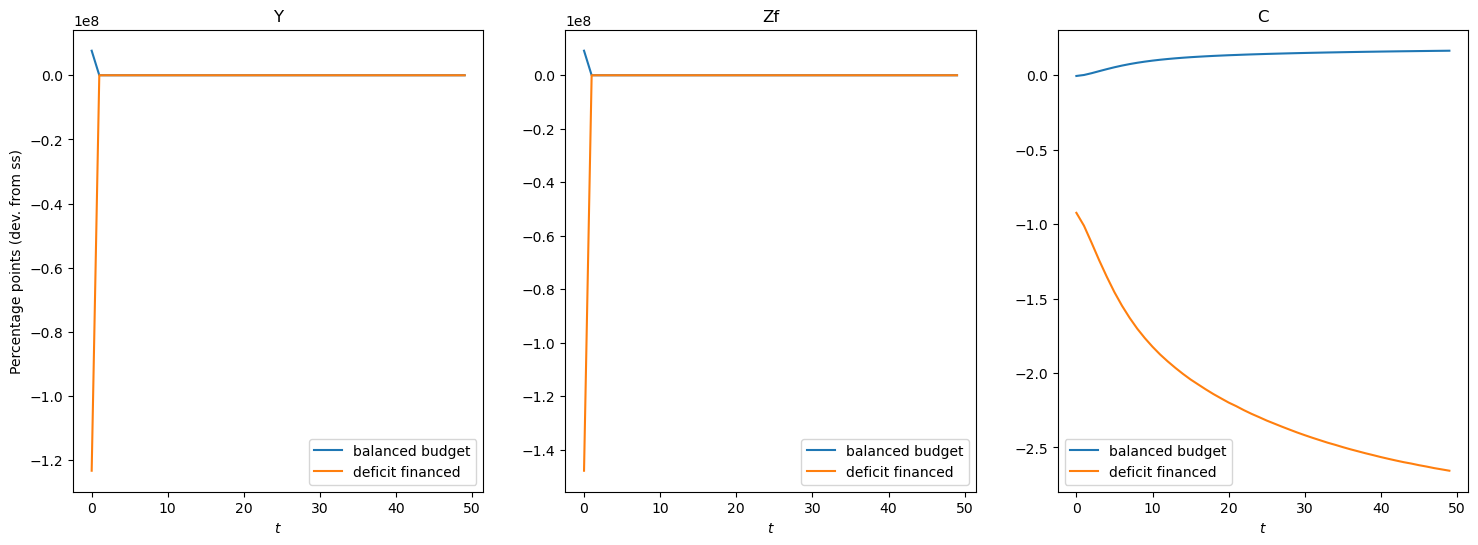

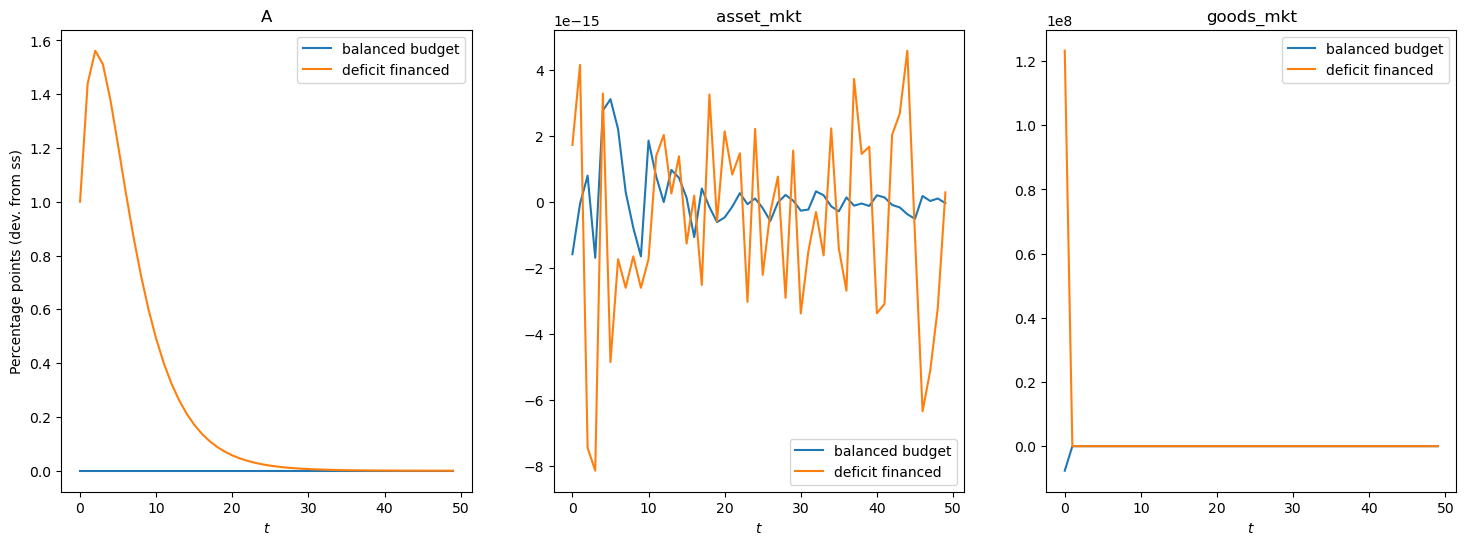

In [33]:
show_irfs([irfs_G, irfs_B], ['G', 'T', 'deficit'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['Y', 'Zi', 'C'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['Y', 'Zf', 'C'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['A', 'asset_mkt', 'goods_mkt'], labels=["balanced budget", "deficit financed"])